# Introduction To Data Science HW Data Cleaning and EDA for Netflix Prize 

## This HW, we need to do the data cleaning for Netflix Prize Data
## In the below is the dataset description
TRAINING DATASET FILE DESCRIPTION
================================================================================
In this part, we have 4 files "combined_data_1.txt", "combined_data_2.txt", "combined_data_3.txt", "combined_data_4.txt"

THe format is in the below: 

CustomerID,Rating,Date

- MovieIDs range from 1 to 17770 sequentially.
- CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users.
- Ratings are on a five star (integral) scale from 1 to 5.
- Dates have the format YYYY-MM-DD.

MOVIES FILE DESCRIPTION
================================================================================

Movie information in "movie_titles.csv" is in the following format:

MovieID,YearOfRelease,Title

- MovieID do not correspond to actual Netflix movie ids or IMDB movie ids.
- YearOfRelease can range from 1890 to 2005 and may correspond to the release of
  corresponding DVD, not necessarily its theaterical release.
- Title is the Netflix movie title and may not correspond to 
  titles used on other sites.  Titles are in English.

# First Deal with training set data cleaning

In [2]:
# To show graphs in jupyter notebook using %matplotlib inline 
%matplotlib inline 

# Import shutil, numby, pandas, seaborn, matplotlib.pyplot, dask.dataframe, dask.array libraries
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Combine all combined data together into one 2G csv file
with open("/Users/ChienMingHuang/Desktop/netflix-prize-data/combined_data.csv",'w') as wfd:
    for f in ["/Users/ChienMingHuang/Desktop/netflix-prize-data/combined_data_1.txt", "/Users/ChienMingHuang/Desktop/netflix-prize-data/combined_data_2.txt", "/Users/ChienMingHuang/Desktop/netflix-prize-data/combined_data_3.txt", "/Users/ChienMingHuang/Desktop/netflix-prize-data/combined_data_4.txt"]:
        with open(f,'r') as fd:
            shutil.copyfileobj(fd, wfd, 1024*1024*10)
            #10MB per writing chunk to avoid reading big file into memory.

In [3]:
# Read the combined csv file and give the column names ['CustomerID', 'Rating', 'Date']
train = pd.read_csv("/Users/ChienMingHuang/Desktop/netflix-prize-data/combined_data.csv", header = None, names = ['CustomerID', 'Rating', 'Date'])

# Read the first 5 rows of train
train.head()
# we can see that the file that has some messy becasue the dataset put the customerid and movieid into the same column

,CustomerID,Rating,Date
0,1:,NaN,NaN
1,1488844,3.0,2005-09-06
2,822109,5.0,2005-05-13
3,885013,4.0,2005-10-19
4,30878,4.0,2005-12-26


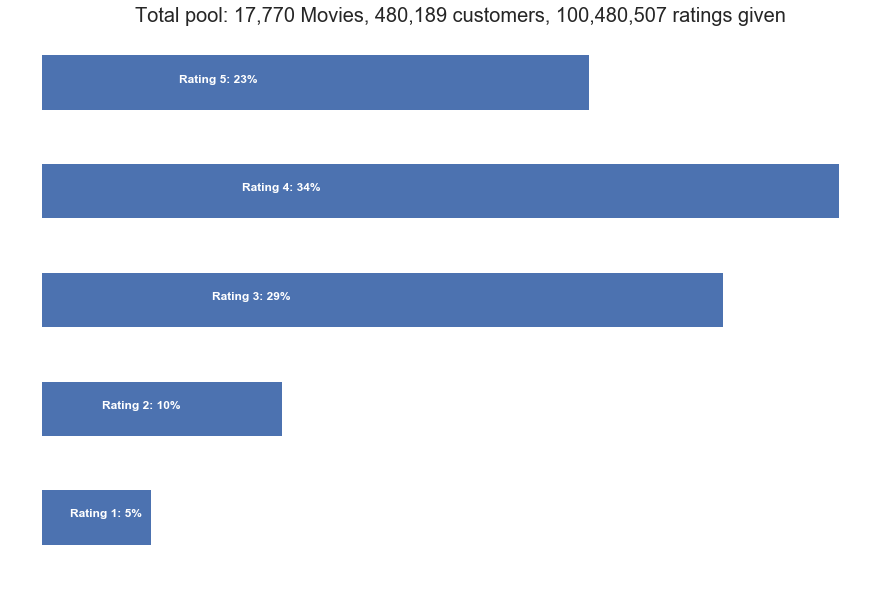

In [14]:
# Using .groupby function to group up rating to do the count
p = train.groupby('Rating')['Rating'].agg(['count'])

# Get movie count using .isnull() and .sum()[1] means sum the answer for the customerid that column since customerid and movieid mixes and null ones mean movies.
movie_count = train.isnull().sum()[1]

# Get customer count using .nunique() for customerid that row and minus the movie_count
cust_count = train['CustomerID'].nunique() - movie_count

# Get rating count using .nunique() for customerid that row and minus the movie_count since customerid and rating are same lengths
rating_count = train['CustomerID'].count() - movie_count

# Using .plot giving the kind use barh for bar and give the figure length for 15 and width for 10
ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))

# Create the plot title to tell how many movies, how many customers, and how many ratings for this dataset, and set up the font size as 20
# We can find out that are 100M records here.
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)

# Remove the plot axis line
plt.axis('off')

# Create the plot using .iloc and show each rating , and doign the format with color white for words and set weight as bold
for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

# We can find out most people giving movies rating 4 then rating 3 for the movies

In [10]:
# In this part, we need to reconstructure the training set
# First we need to find out which rows are movieid rows and pick them out 
# Use dd.Series.isnull() to find train.Rating is NaN then use dd.Series.to_frame convert series to frame
train_nan= pd.DataFrame(pd.isnull(train.Rating))

# Select those true value in Rating which means choosing all the movieid rows
train_nan = train_nan[train_nan.Rating == True]

# Reset the index for train_nan, then keep the origin index representing movieid rows as a column
train_nan = train_nan.reset_index()

# Read the first 5 rows of train_nan which representing the index row of movieid
train_nan.head()

,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True


In [12]:
%%time
# Later we create a numpy list for movieid later to put in
# set movie_np as a list
movie_np = []

# set movie_id starts at 1
movie_id = 1

# build up the movie_np list and using movie_id doing loop and append every movieid for each rating into the column
for i,j in zip(train_nan['index'][1:],train_nan['index'][:-1]):
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

CPU times: user 32min 2s, sys: 49min 11s, total: 1h 21min 14s
Wall time: 1h 24min 33s


In [13]:
# Account for last record and corresponding length
last_record = np.full((1,len(train) - train_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

# Check the movieid list and check the length is the same as train
print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   1.77700000e+04
   1.77700000e+04   1.77700000e+04]
Length: 100480507


In [14]:
# remove those Movie ID rows with NaN Rating field
train = train[pd.notnull(train.Rating)]

# Change the MovieID data type as integer
train['MovieID'] = movie_np.astype(int)

# Change the CustomerID data type as integer
train['CustomerID'] = train['CustomerID'].astype(int)

# Change the Date data type as date time
train['Date'] = pd.to_datetime(train['Date'], format='%Y-%m-%d')

# Read the first 5 rows of train with correct column that shows customerid, rating, date, movieid
train.head()

,CustomerID,Rating,Date,MovieID
1,1488844,3.0,2005-09-06,1
2,822109,5.0,2005-05-13,1
3,885013,4.0,2005-10-19,1
4,30878,4.0,2005-12-26,1
5,823519,3.0,2004-05-03,1


In [15]:
# Check missing values in each column
train.isnull().sum()

CustomerID    0
Rating        0
Date          0
MovieID       0
dtype: int64

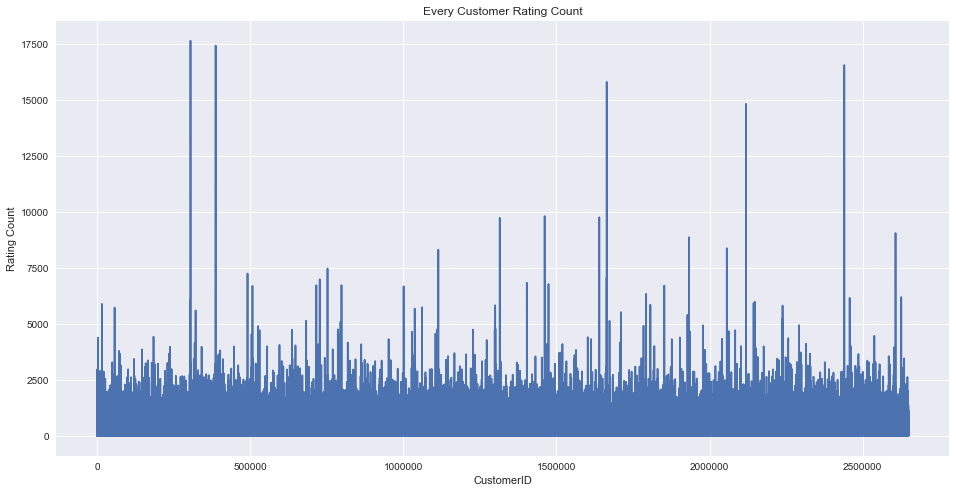

In [16]:
# Every Customer rating count
# Use.value_counts() for date and sample as month to do the sum

# Set up the plot figure with size 16inches for length and 8 inches for width
plt.figure(figsize=(16,8))

c = train.groupby('CustomerID')['CustomerID'].agg(['count'])
c.head()

# Set up plot xlabel='CustomerID'
plt.xlabel('CustomerID') 

# Set up plot ylabel='Rating Count'
plt.ylabel('Rating Count') 

# Set up plot title="Every Customer Rating Count"
plt.title("Every Customer Rating Count") 

# Create the plot using .plot()
plt.plot(c)


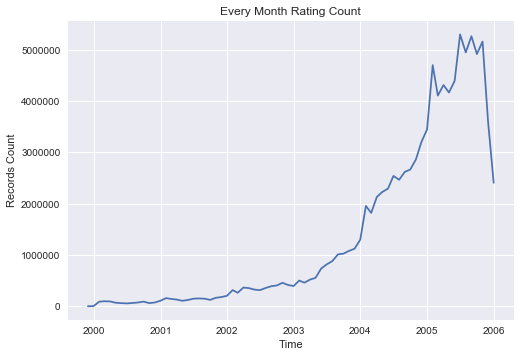

In [17]:
# Every month rating count
# Use.value_counts() for date and sample as month to do the sum
a = train['Date'].value_counts().resample('M').sum()

# Set up plot xlabel='Time'
plt.xlabel('Time') 

# Set up plot ylabel='Records Count'
plt.ylabel('Records Count') 

# Set up plot title="Every Month Rating Count"
plt.title("Every Month Rating Count") 

# Create the plot using .plot()
plt.plot(a)
# We can find 2005 that year has lots of rating, so we probably can assume that Netflix gets lot of users at that time
# Also 2004 that year was a big increase for Netflix user giving ratings

In [18]:
# Create new csv for future analyzing this netflix dataset using .to_csv() and set sep as comma
train.to_csv("/Users/ChienMingHuang/Desktop/netflix-prize-data/train.csv", sep=',')

# Second Deal with movie_titles.csv data cleaning

In [15]:
# To deal with extra commas in movie title, we need to change the delimiter to |
# Import csv library
import csv

# set the origin file as f and fixed file as g, and do the encoding="ISO-8859-1" to prevent unicode encoding problem
# Use csv.writer() and change the delimiter = |
# The problem is that movie_title has extra comma inside, so we only do the split with first 2 commas
with open("/Users/ChienMingHuang/Desktop/netflix-prize-data/movie_titles.csv", 'r', encoding="ISO-8859-1") as f, open("/Users/ChienMingHuang/Desktop/netflix-prize-data/movie_titles_revised.csv", 'w', encoding="ISO-8859-1") as g:
    writer = csv.writer(g, delimiter='|')
    for line in f:
        row = line.split(',', 2)
        writer.writerow(row)

In [136]:
# read movie_title revised csv and check the file 
movie= pd.read_csv("/Users/ChienMingHuang/Desktop/netflix-prize-data/movie_titles_revised.csv", sep ='|', header = None, encoding ="ISO-8859-1")

# Read the first 5 rows of movie
movie.head()
# We found out we have to give the header name and fix the data type, that year has no .0 and the movie title has remove \n

,0,1,2
0,1,2003.0,Dinosaur Planet\n
1,2,2004.0,Isle of Man TT 2004 Review\n
2,3,1997.0,Character\n
3,4,1994.0,Paula Abdul's Get Up & Dance\n
4,5,2004.0,The Rise and Fall of ECW\n


In [137]:
# Add movie header as the netflix description
movie.columns = ["MovieID", "YearOfRelease", "Title"]

# Read the first 5 rows of movie and check the header
movie.head()

,MovieID,YearOfRelease,Title
0,1,2003.0,Dinosaur Planet\n
1,2,2004.0,Isle of Man TT 2004 Review\n
2,3,1997.0,Character\n
3,4,1994.0,Paula Abdul's Get Up & Dance\n
4,5,2004.0,The Rise and Fall of ECW\n


In [138]:
# Change YearOfRelase datatype using astype() to object
movie.YearOfRelease = movie.YearOfRelease.astype(object)

# Read the first 5 rows of movie and check the YearOfRelase
movie.head()

,MovieID,YearOfRelease,Title
0,1,2003,Dinosaur Planet\n
1,2,2004,Isle of Man TT 2004 Review\n
2,3,1997,Character\n
3,4,1994,Paula Abdul's Get Up & Dance\n
4,5,2004,The Rise and Fall of ECW\n


In [139]:
# Remove the regular expression in Title using .replace() to remove \n, and set regex= True
movie.Title = movie.Title.replace('\n','', regex=True)

# Read the first 5 rows of movie and check the Title
movie.head()

,MovieID,YearOfRelease,Title
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW


In [140]:
# Check missing values in each column
movie.isnull().sum()
# We find out there are 7 missing values in the YearOfRelease, we can later set them as NaN

MovieID          0
YearOfRelease    7
Title            0
dtype: int64

In [141]:
# Set the missing value in YearOfRelease as unknown
movie = movie.fillna('unknown')

# 
pd.to_numeric(movie['YearOfRelease'], errors='ignore')

# Check missing values in each column
movie.isnull().sum()

MovieID          0
YearOfRelease    0
Title            0
dtype: int64

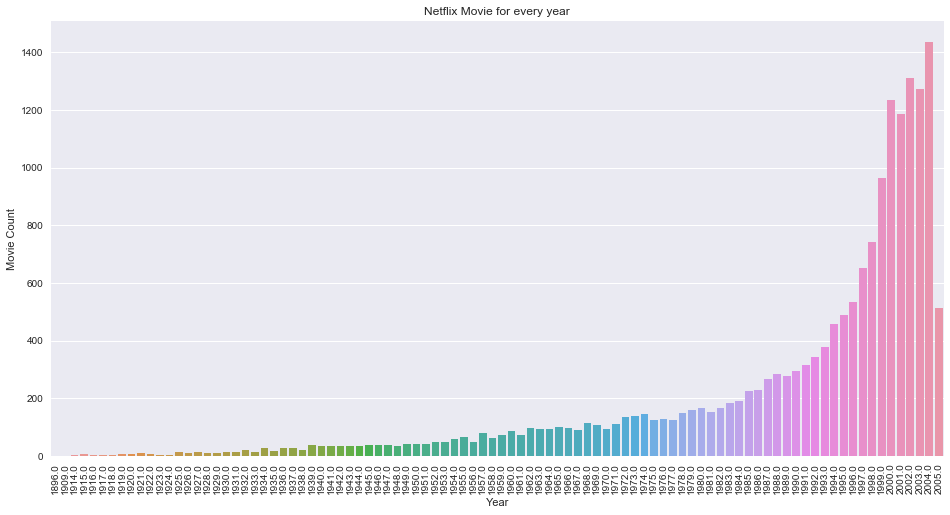

In [148]:
# Netflix Movie for every year plot
# Set up yearstuff remove the movies with unknown year of release 
yearstuff= movie[movie.YearOfRelease != 'unknown']

# Set up the plot figure with size 16inches for length and 8 inches for width
plt.figure(figsize=(16,8))

# Use .countplot() to do the count plot
movieyear = sns.countplot(x="YearOfRelease", data=yearstuff)

# Set the xlabel for rotation 90 degrees using .xticks()
plt.xticks(rotation=90) 

# Set up plot xlabel='Year'
plt.xlabel('Year') 

# Set up plot ylabel='Movie Count'
plt.ylabel('Movie Count') 

# Set up plot title="Netflix Movie for every year"
plt.title("Netflix Movie for every year") 

# We can find out the 2000s have lots of movies especially 2004 Netflix has 1400 movies.

# Reference:
1. https://www.kaggle.com/netflix-inc/netflix-prize-data/data
2. https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html
3. https://www.kaggle.com/laowingkin/movie-recommendation-with-netflix/notebook
